In [13]:
!pip install numpy pandas matplotlib seaborn statsmodels scikit-learn yfinance
!pip install --upgrade yfinance


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm
from sklearn.cluster import KMeans
import yfinance as yf
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings('ignore')


In [15]:
class PairsTrading:
    def __init__(self,  symbols=None, start_date=None, end_date=None, initial_capital=100000):
        self.symbols = symbols
        self.start_date = start_date
        self.end_date = end_date
        self.prices = None
        self.pairs = []
        self.selected_pairs = []
        self.results = {}
        self.portfolio = None
        self.portfolio_metrics = None
        self.initial_capital = initial_capital

    def load_data(self):
        if self.symbols and self.start_date and self.end_date:
            print(f"Downloading data for {len(self.symbols)} symbols from {self.start_date} to {self.end_date}")
            data = yf.download(self.symbols, start=self.start_date, end=self.end_date, auto_adjust=False)
            self.prices = data['Adj Close']
        else:
            raise ValueError("Either provide a data path or symbols with date range")
        self.prices = self.prices.dropna(axis=1)
        print(f"Data loaded with {self.prices.shape[1]} assets and {self.prices.shape[0]} days")
        return self.prices

    def find_cointegrated_pairs(self, training_start_date, training_end_date, significance_level=0.05):
        training_data = self.prices.loc[training_start_date:training_end_date]
        n = training_data.shape[1]
        keys = training_data.columns
        pairs = []
        total_tests = n * (n - 1) // 2
        test_count = 0
        print(f"Testing {total_tests} potential pairs for cointegration...")
        for i in range(n):
            for j in range(i+1, n):
                test_count += 1
                if test_count % 50 == 0:
                    print(f"Completed {test_count}/{total_tests} tests")

                asset1 = keys[i]
                asset2 = keys[j]
                correlation = training_data[asset1].corr(training_data[asset2])
                if abs(correlation) < 0.5:
                    continue
                log_price1 = np.log(training_data[asset1])
                log_price2 = np.log(training_data[asset2])
                score, pvalue, _ = coint(log_price1, log_price2)

                if pvalue < significance_level:
                    model = sm.OLS(log_price1, sm.add_constant(log_price2))
                    result = model.fit()
                    hedge_ratio = result.params[log_price2.name]
                    spread = log_price1 - hedge_ratio * log_price2
                    adf_result = adfuller(spread)

                    if adf_result[1] < significance_level:
                        pairs.append((asset1, asset2, pvalue, hedge_ratio, adf_result[1], correlation))

        self.pairs = sorted(pairs, key=lambda x: x[2])
        print(f"Found {len(self.pairs)} cointegrated pairs")
        return self.pairs

    def select_best_pairs(self, max_pairs=5):
        if not self.pairs:
            raise ValueError("No pairs found. Run find_cointegrated_pairs first.")
        self.selected_pairs = self.pairs[:min(max_pairs, len(self.pairs))]

        print(f"Selected {len(self.selected_pairs)} pairs for trading:")
        for i, pair in enumerate(self.selected_pairs, 1):
            asset1, asset2, pvalue, hedge_ratio, adf_pvalue, correlation = pair
            print(f"{i}. {asset1}-{asset2}: p-value={pvalue:.6f}, hedge ratio={hedge_ratio:.4f}, correlation={correlation:.4f}")

        return self.selected_pairs


    def calculate_hedge_ratio(self, asset1, asset2, data=None):
        if data is None:
            data = self.prices

        log_price1 = np.log(data[asset1])
        log_price2 = np.log(data[asset2])

        model = sm.OLS(log_price1, sm.add_constant(log_price2))
        result = model.fit()
        return result.params[log_price2.name]

    def backtest_pair(self, asset1, asset2, training_start_date, training_end_date,
                      testing_start_date, testing_end_date, entry_threshold=1.0,
                      exit_threshold=0.25, lookback=30, transaction_cost=0.001,
                      capital_per_pair=None):

        training_data = self.prices.loc[training_start_date:training_end_date]
        testing_data = self.prices.loc[testing_start_date:testing_end_date]

        hedge_ratio = self.calculate_hedge_ratio(asset1, asset2, training_data)

        log_price1 = np.log(testing_data[asset1])
        log_price2 = np.log(testing_data[asset2])

        spread = log_price1 - hedge_ratio * log_price2

        spread_mean = spread.rolling(window=lookback).mean()
        spread_std = spread.rolling(window=lookback).std()
        z_score = (spread - spread_mean) / spread_std

        positions = pd.DataFrame(index=z_score.index)
        positions['z_score'] = z_score

        positions['signal'] = 0

        # Entry signals
        positions.loc[z_score > entry_threshold, 'signal'] = -1
        positions.loc[z_score < -entry_threshold, 'signal'] = 1

        exit_condition = (abs(z_score) < exit_threshold) & (positions['signal'].shift(1) != 0)
        positions.loc[exit_condition, 'signal'] = 0


        positions['signal'] = positions['signal'].replace(to_replace=0, method='ffill')


        positions['asset1'] = positions['signal']
        positions['asset2'] = -positions['signal'] * hedge_ratio


        asset1_returns = testing_data[asset1].pct_change()
        asset2_returns = testing_data[asset2].pct_change()


        positions['asset1_return'] = positions['asset1'].shift(1) * asset1_returns
        positions['asset2_return'] = positions['asset2'].shift(1) * asset2_returns
        positions['strategy_return'] = positions['asset1_return'] + positions['asset2_return']


        positions['trade'] = positions['signal'].diff().fillna(0) != 0
        positions.loc[positions['trade'], 'strategy_return'] -= transaction_cost


        trade_count = positions['trade'].sum()


        if capital_per_pair is not None:
            positions['portfolio_value'] = capital_per_pair * (1 + positions['strategy_return'].fillna(0)).cumprod()
        else:
            positions['portfolio_value'] = (1 + positions['strategy_return'].fillna(0)).cumprod()


        if len(positions) > 0:
            total_return = positions['portfolio_value'].iloc[-1] / positions['portfolio_value'].iloc[0] - 1 if not pd.isna(positions['portfolio_value'].iloc[-1]) else 0


            if total_return > -1:
                annual_return = (1 + total_return) ** (252 / len(positions)) - 1
            else:
                annual_return = -1

            daily_returns = positions['strategy_return'].dropna()

            if len(daily_returns) > 0 and daily_returns.std() > 0:
                sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std()
            else:
                sharpe_ratio = 0

            max_drawdown = (positions['portfolio_value'] / positions['portfolio_value'].cummax() - 1).min() if len(positions) > 0 else 0
            win_rate = len(daily_returns[daily_returns > 0]) / len(daily_returns) if len(daily_returns) > 0 else 0
        else:
            total_return = 0
            annual_return = 0
            sharpe_ratio = 0
            max_drawdown = 0
            win_rate = 0


        results = {
            'pair': (asset1, asset2),
            'hedge_ratio': hedge_ratio,
            'positions': positions,
            'total_return': total_return,
            'annual_return': annual_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'win_rate': win_rate,
            'trade_count': trade_count,
            'spread': spread,
            'z_score': z_score
        }

        return results

    def backtest_portfolio(self, training_start_date, training_end_date,
                          testing_start_date, testing_end_date, entry_threshold=1.0,
                          exit_threshold=0.25, lookback=30, transaction_cost=0.001):

        if not self.selected_pairs:
            raise ValueError("No pairs selected. Run select_best_pairs first.")


        capital_per_pair = self.initial_capital / len(self.selected_pairs)


        self.results = {}
        for pair in self.selected_pairs:
            asset1, asset2 = pair[0], pair[1]
            print(f"Backtesting pair: {asset1}-{asset2}")

            result = self.backtest_pair(
                asset1, asset2,
                training_start_date=training_start_date,
                training_end_date=training_end_date,
                testing_start_date=testing_start_date,
                testing_end_date=testing_end_date,
                entry_threshold=entry_threshold,
                exit_threshold=exit_threshold,
                lookback=lookback,
                transaction_cost=transaction_cost,
                capital_per_pair=capital_per_pair
            )

            self.results[(asset1, asset2)] = result


        self.calculate_portfolio_performance()

        return self.results

    def calculate_portfolio_performance(self):

        if not self.results:
            raise ValueError("No results available. Run backtest_portfolio first.")


        all_dates = set()
        for pair, result in self.results.items():
            all_dates.update(result['positions'].index)


        portfolio = pd.DataFrame(index=sorted(all_dates))
        portfolio['portfolio_value'] = 0


        for pair, result in self.results.items():
            positions = result['positions']
            portfolio.loc[positions.index, f'{pair[0]}_{pair[1]}_value'] = positions['portfolio_value']


        value_columns = [col for col in portfolio.columns if col.endswith('_value') and col != 'portfolio_value']
        for col in value_columns:
            portfolio[col] = portfolio[col].fillna(method='ffill')


        portfolio['portfolio_value'] = portfolio[value_columns].sum(axis=1)


        portfolio['portfolio_return'] = portfolio['portfolio_value'].pct_change()

        portfolio['cumulative_return'] = portfolio['portfolio_value'] / self.initial_capital - 1


        if len(portfolio) > 0:
            total_return = portfolio['portfolio_value'].iloc[-1] / self.initial_capital - 1
            annual_return = (1 + total_return) ** (252 / len(portfolio)) - 1
            daily_returns = portfolio['portfolio_return'].dropna()

            if len(daily_returns) > 0 and daily_returns.std() > 0:
                sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std()
            else:
                sharpe_ratio = 0

            max_drawdown = (portfolio['portfolio_value'] / portfolio['portfolio_value'].cummax() - 1).min()
        else:
            total_return = 0
            annual_return = 0
            sharpe_ratio = 0
            max_drawdown = 0


        total_trades = sum(result['trade_count'] for result in self.results.values())


        self.portfolio = portfolio
        self.portfolio_metrics = {
            'total_return': total_return,
            'annual_return': annual_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'total_trades': total_trades
        }

        return portfolio


    def plot_closing_prices(self, results):
        asset1, asset2 = results['pair']
        plt.figure(figsize=(12, 6))
        plt.plot(self.prices[asset1], label=asset1)
        plt.plot(self.prices[asset2], label=asset2)
        plt.title(f'Closing Prices: {asset1} vs {asset2}')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_rel_close_price(self, results):
        asset1, asset2 = results['pair']
        plt.figure(figsize=(12, 6))
        normalized_1 = self.prices[asset1] / self.prices[asset1].iloc[0]
        normalized_2 = self.prices[asset2] / self.prices[asset2].iloc[0]
        plt.plot(normalized_1, label=f'{asset1} (Normalized)')
        plt.plot(normalized_2, label=f'{asset2} (Normalized)')
        plt.title('Relative Closing Prices (Normalized to Starting Value)')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_long_short_positions(self, results):
        asset1, asset2 = results['pair']
        positions = results['positions']
        plt.figure(figsize=(12, 6))
        plt.plot(positions['asset1'], label=f'{asset1} Position')
        plt.plot(positions['asset2'], label=f'{asset2} Position')
        plt.title('Long-Short Positions')
        plt.legend()
        plt.grid(True)
        plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        plt.show()

    def plot_PnL(self, results):
        asset1, asset2 = results['pair']
        positions = results['positions']
        plt.figure(figsize=(12, 6))

        # Calculate cumulative returns for plotting
        asset1_cum_return = (1 + positions['asset1_return'].fillna(0)).cumprod() - 1
        asset2_cum_return = (1 + positions['asset2_return'].fillna(0)).cumprod() - 1
        strategy_cum_return = (1 + positions['strategy_return'].fillna(0)).cumprod() - 1

        plt.plot(asset1_cum_return, label=f'{asset1} Cumulative Return')
        plt.plot(asset2_cum_return, label=f'{asset2} Cumulative Return')
        plt.plot(strategy_cum_return, label='Combined Strategy Return')
        plt.title('PnL Calculations (Cumulative Returns)')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_portfolio_curve(self, results):
        asset1, asset2 = results['pair']
        positions = results['positions']
        plt.figure(figsize=(12, 6))
        plt.plot(positions['portfolio_value'], label='Portfolio Value')
        plt.title('Portfolio Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_drawdown(self, results):
        asset1, asset2 = results['pair']
        positions = results['positions']
        drawdown = (positions['portfolio_value'] / positions['portfolio_value'].cummax() - 1)
        plt.figure(figsize=(12, 6))
        plt.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
        plt.title('Portfolio Drawdown')
        plt.grid(True)
        plt.show()

    def plot_zscore(self, results):
        z_score = results['z_score']
        positions = results['positions']
        asset1, asset2 = results['pair']

        plt.figure(figsize=(14, 6))
        plt.plot(z_score, label='z-score')
        plt.title(f"z-score {asset2}-{asset1}")
        plt.xlabel("Time")
        plt.ylabel("Values")
        plt.axhline(y=1, color='r', label='1 threshold')
        plt.axhline(y=-1, color='g', label='-1 threshold')
        plt.axhline(y=0, color='k', linestyle='--')


        if 'signal' in positions.columns:
            plt.fill_between(positions.index, -5, 5,
                           where=positions['signal'] == 1,
                           color='green', alpha=0.1, label='Long Position')
            plt.fill_between(positions.index, -5, 5,
                           where=positions['signal'] == -1,
                           color='red', alpha=0.1, label='Short Position')

        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_portfolio_performance(self):

        if not hasattr(self, 'portfolio'):
            raise ValueError("Portfolio not calculated. Run calculate_portfolio_performance first.")

        fig, axs = plt.subplots(2, 1, figsize=(14, 10))


        axs[0].plot(self.portfolio['portfolio_value'], label='Portfolio Value')
        axs[0].set_title('Portfolio Value Over Time')
        axs[0].legend()
        axs[0].grid(True)


        drawdown = (self.portfolio['portfolio_value'] / self.portfolio['portfolio_value'].cummax() - 1)
        axs[1].fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
        axs[1].set_title('Portfolio Drawdown')
        axs[1].set_ylim(-1, 0)
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

    def performance_metrics(self, results):
        print("\nPerformance Metrics:")
        print(f"Total Return: {results['total_return']:.2%}")
        print(f"Annual Return: {results['annual_return']:.2%}")
        print(f"Sharpe Ratio: {results['sharpe_ratio']:.2f}")
        print(f"Max Drawdown: {results['max_drawdown']:.2%}")
        print(f"Win Rate: {results['win_rate']:.2%}")
        print(f"Number of Trades: {results['trade_count']}")

    def portfolio_performance_metrics(self):
        """
        Print portfolio performance metrics
        """
        if not hasattr(self, 'portfolio_metrics'):
            raise ValueError("Portfolio metrics not calculated. Run calculate_portfolio_performance first.")

        print("\nPortfolio Performance Metrics:")
        print(f"Initial Capital: ₹{self.initial_capital:,.2f}")
        print(f"Final Portfolio Value: ₹{self.portfolio['portfolio_value'].iloc[-1]:,.2f}")
        print(f"Total Return: {self.portfolio_metrics['total_return']:.2%}")
        print(f"Annual Return: {self.portfolio_metrics['annual_return']:.2%}")
        print(f"Sharpe Ratio: {self.portfolio_metrics['sharpe_ratio']:.2f}")
        print(f"Max Drawdown: {self.portfolio_metrics['max_drawdown']:.2%}")
        print(f"Total Number of Trades: {self.portfolio_metrics['total_trades']}")


[                       0%                       ]

[*********************100%***********************]  23 of 23 completed


Data loaded with 22 assets and 1483 days
Testing 231 potential pairs for cointegration...
Completed 50/231 tests
Completed 100/231 tests
Completed 150/231 tests
Completed 200/231 tests
Found 27 cointegrated pairs
Selected 3 pairs for trading:
1. INFY.NS-TCS.NS: p-value=0.000243, hedge ratio=1.5044, correlation=0.9844
2. HCLTECH.NS-TCS.NS: p-value=0.005792, hedge ratio=1.3415, correlation=0.9878
3. BSOFT.NS-INFY.NS: p-value=0.008081, hedge ratio=1.9294, correlation=0.9835
Backtesting pair: INFY.NS-TCS.NS
Backtesting pair: HCLTECH.NS-TCS.NS
Backtesting pair: BSOFT.NS-INFY.NS


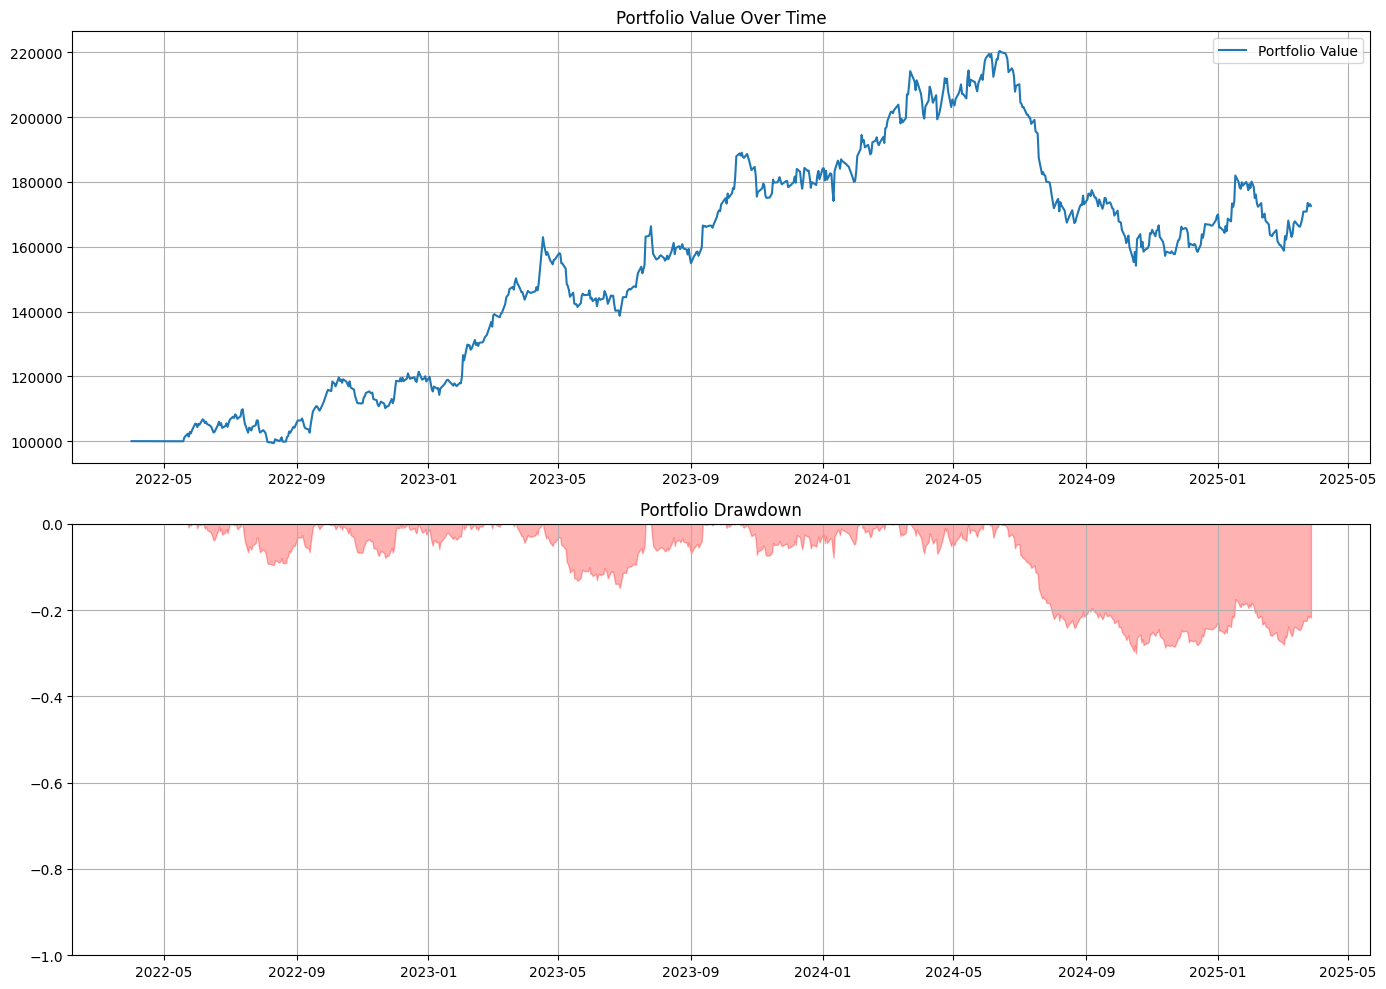


Portfolio Performance Metrics:
Initial Capital: ₹100,000.00
Final Portfolio Value: ₹172,586.52
Total Return: 72.59%
Annual Return: 20.42%
Sharpe Ratio: 1.01
Max Drawdown: -30.06%
Total Number of Trades: 46

Analyzing pair: INFY.NS-TCS.NS


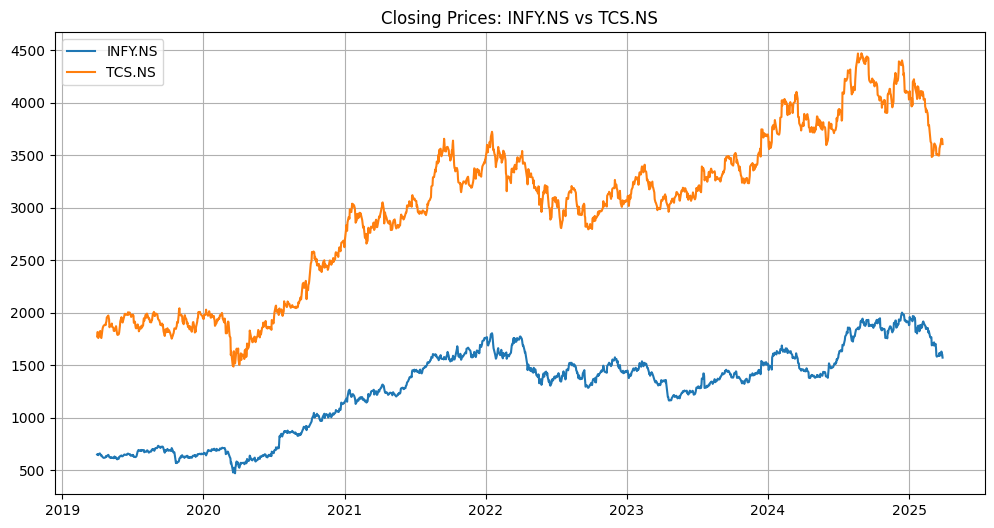

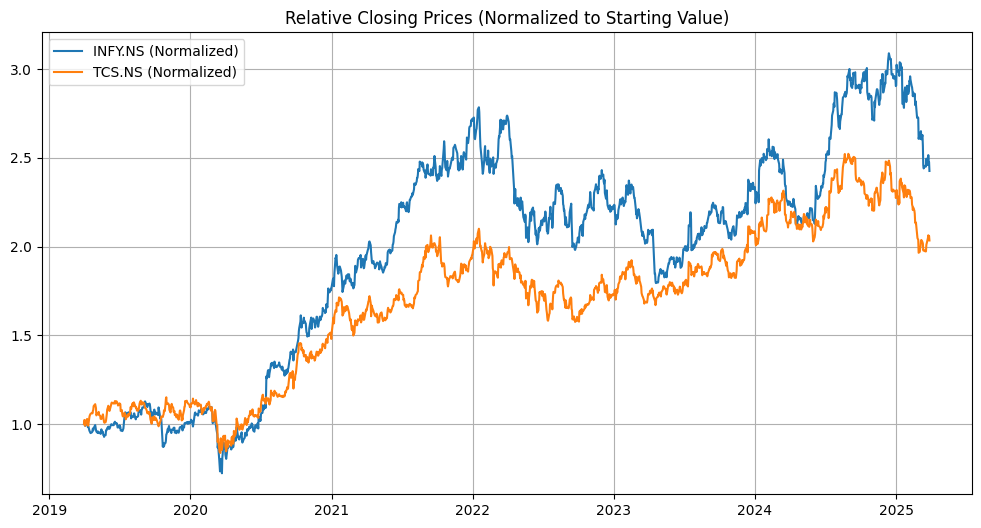

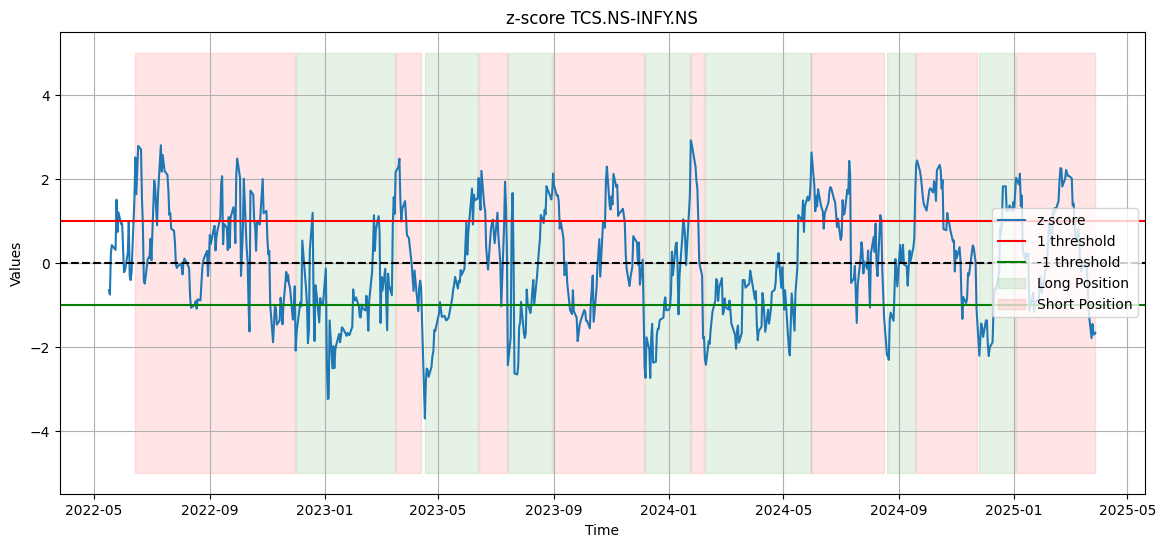

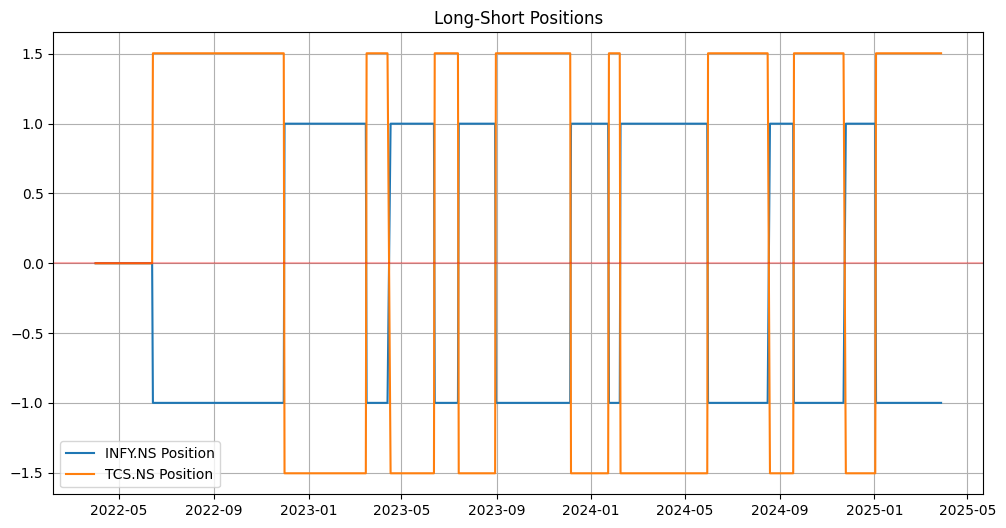

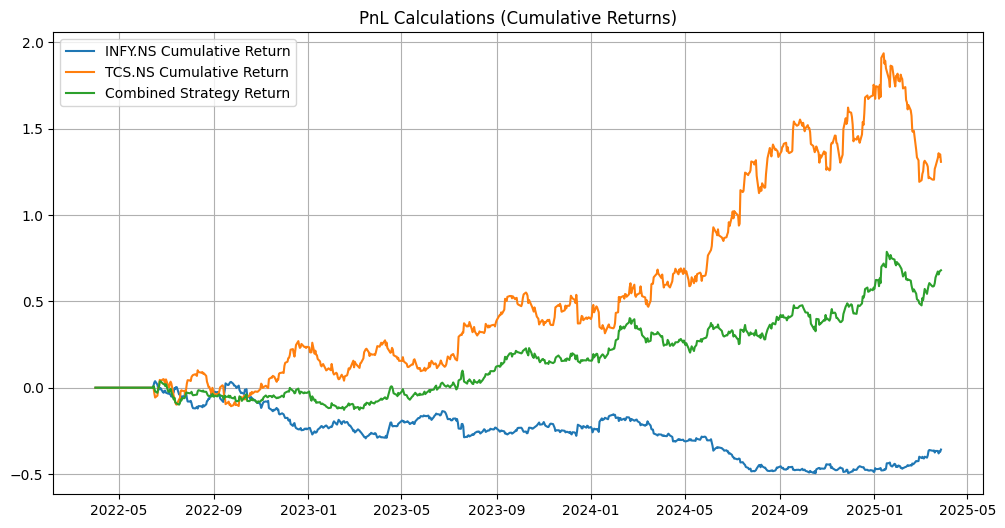

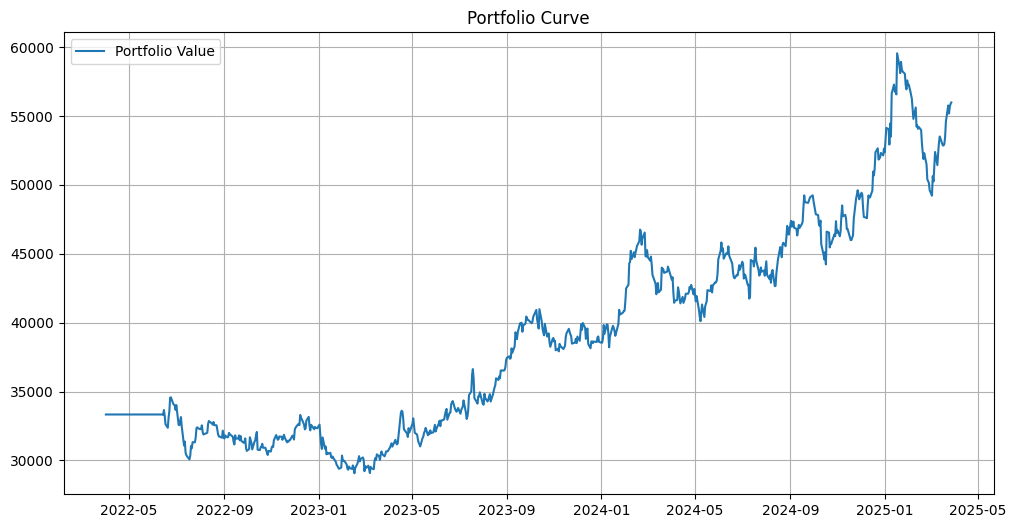

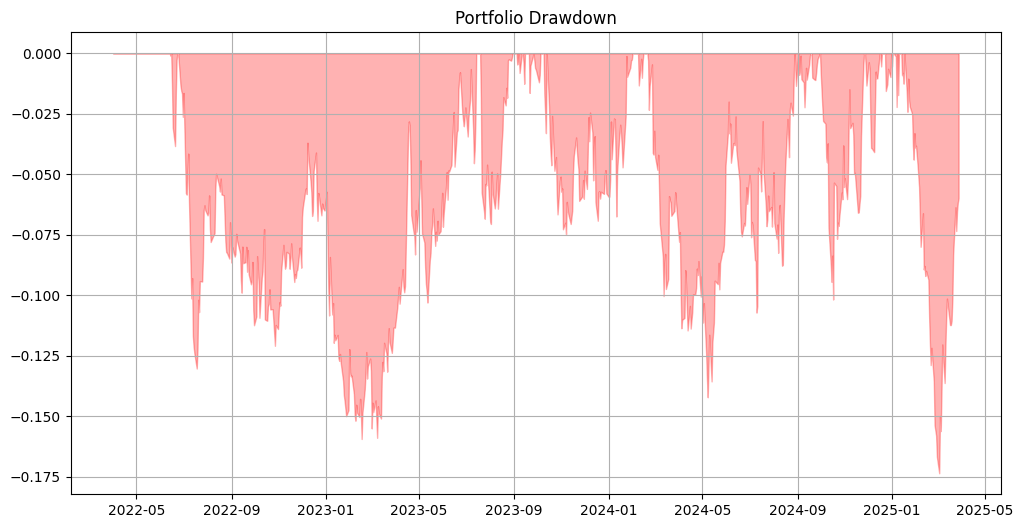


Performance Metrics:
Total Return: 67.97%
Annual Return: 19.32%
Sharpe Ratio: 0.95
Max Drawdown: -17.36%
Win Rate: 47.63%
Number of Trades: 15




Analyzing pair: HCLTECH.NS-TCS.NS


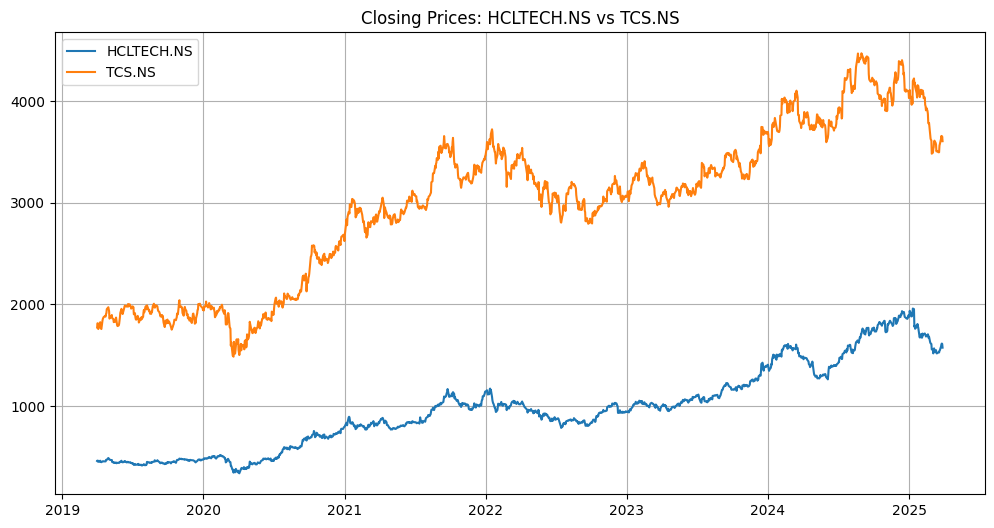

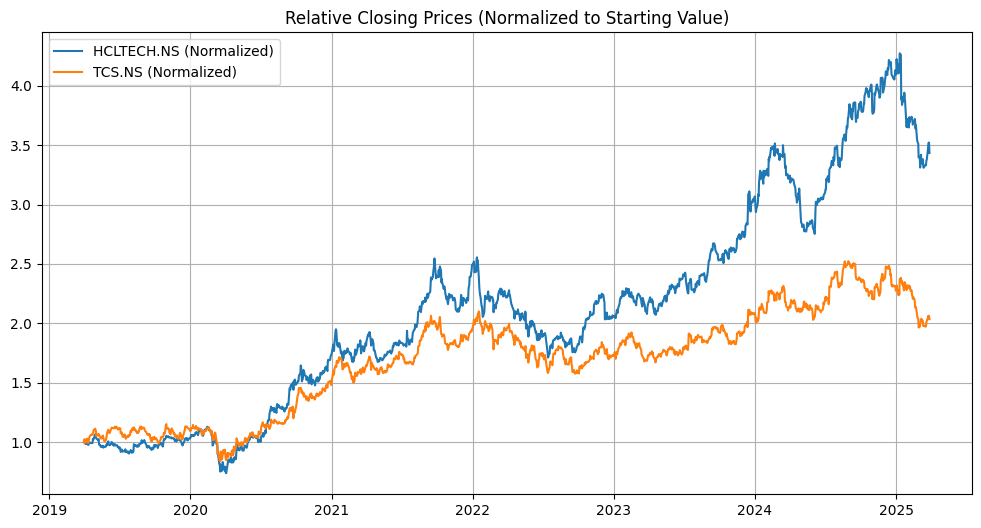

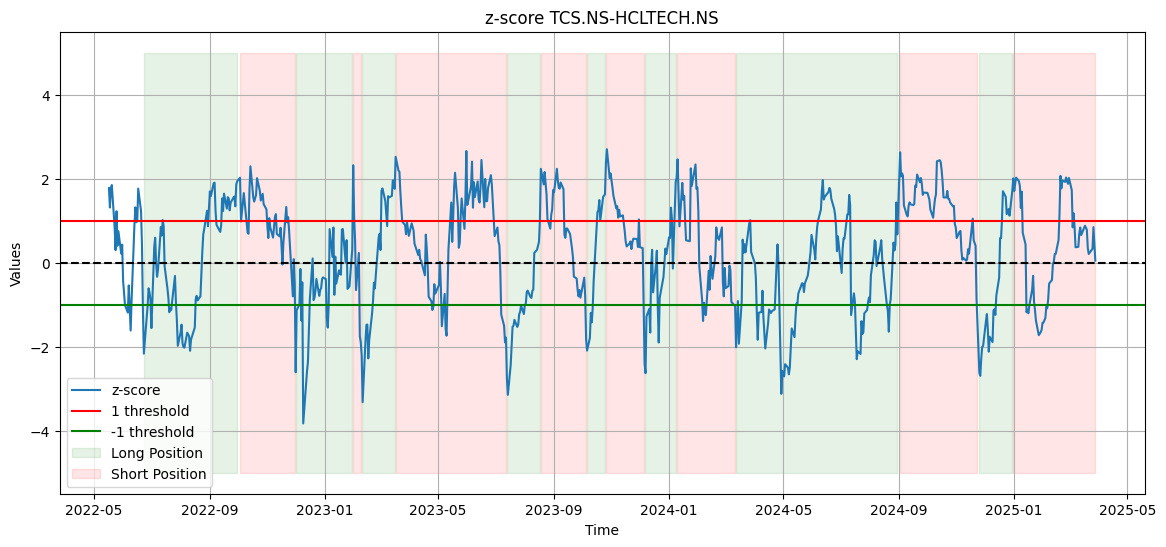

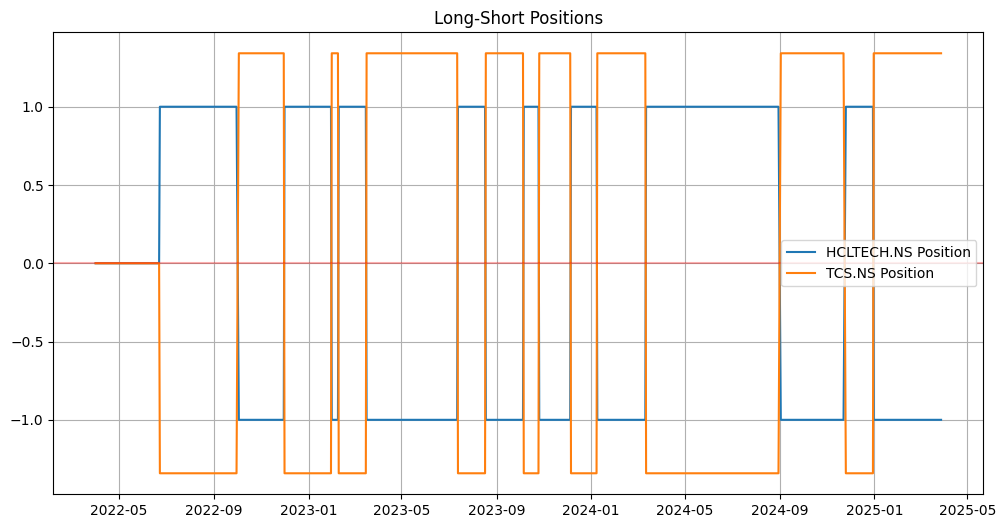

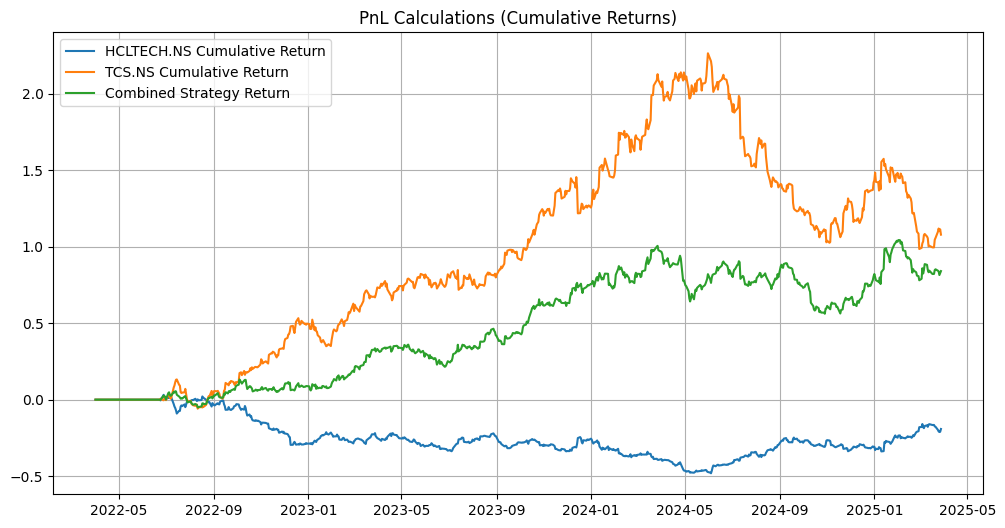

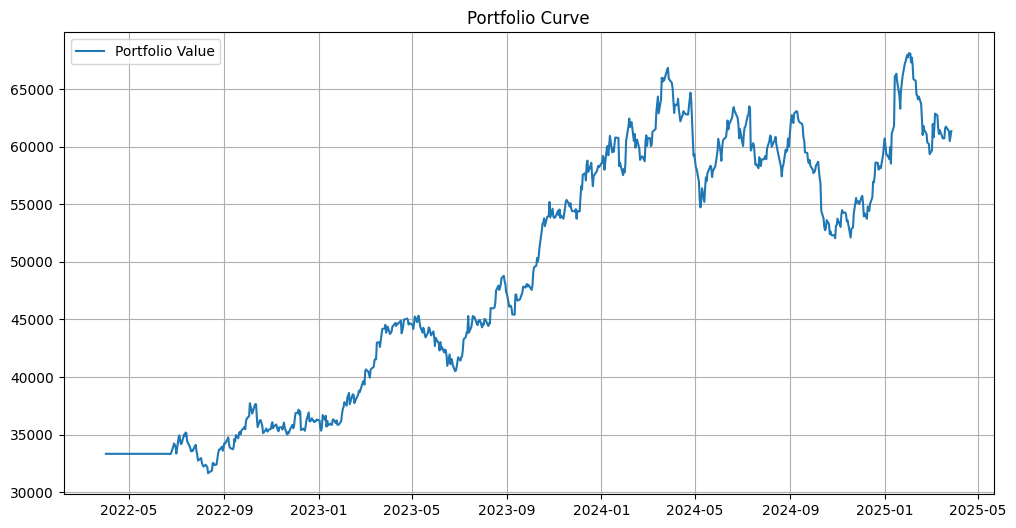

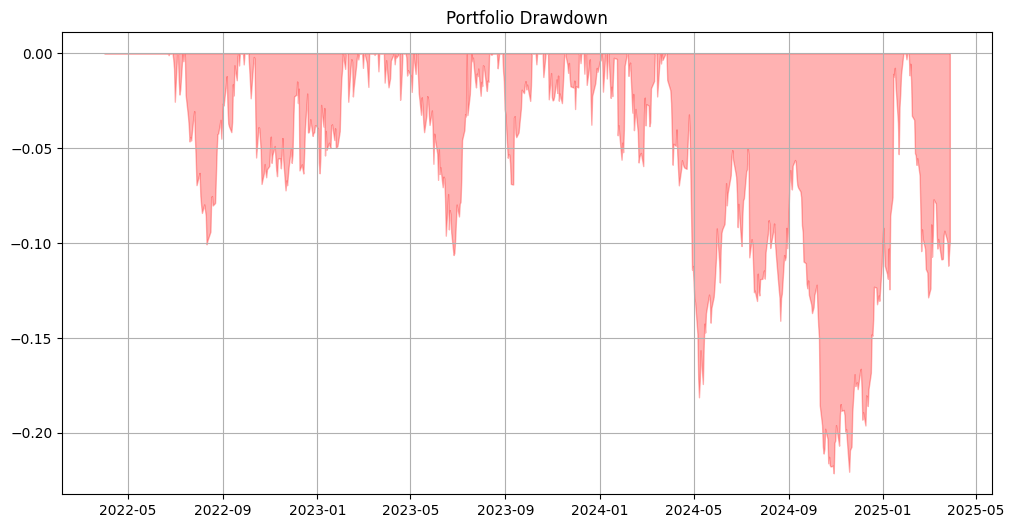


Performance Metrics:
Total Return: 84.04%
Annual Return: 23.09%
Sharpe Ratio: 1.13
Max Drawdown: -22.13%
Win Rate: 50.61%
Number of Trades: 16




Analyzing pair: BSOFT.NS-INFY.NS


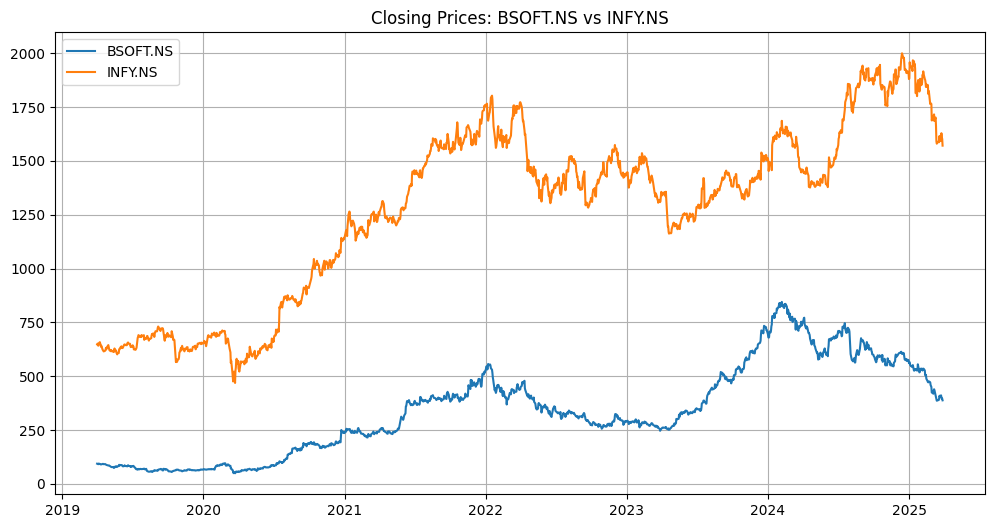

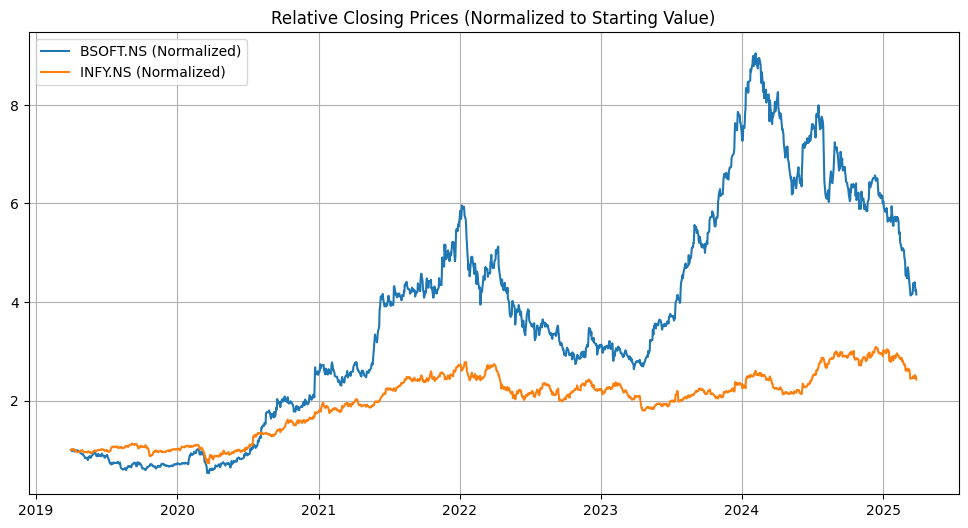

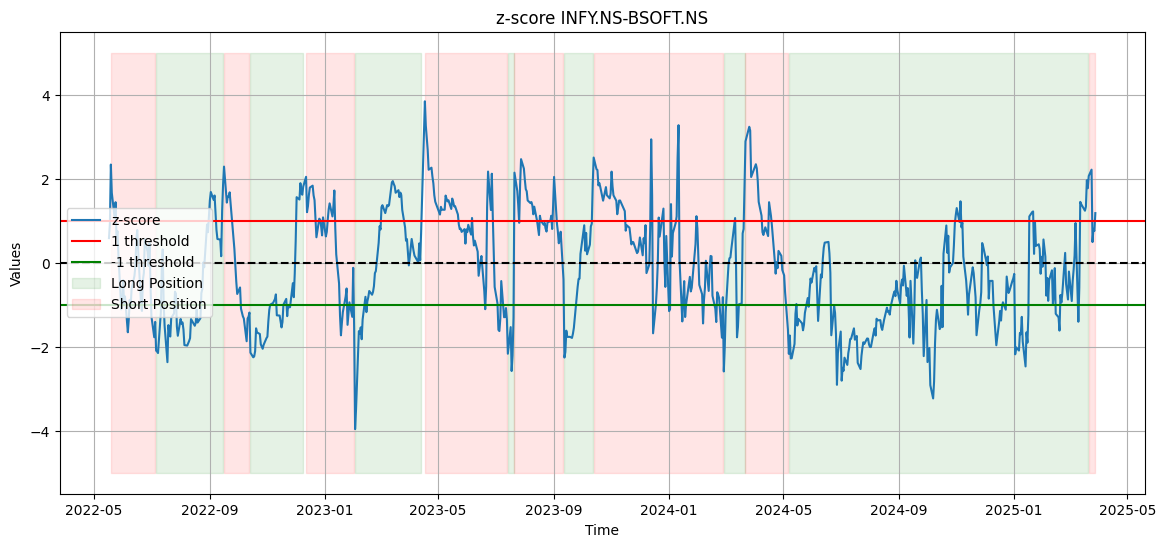

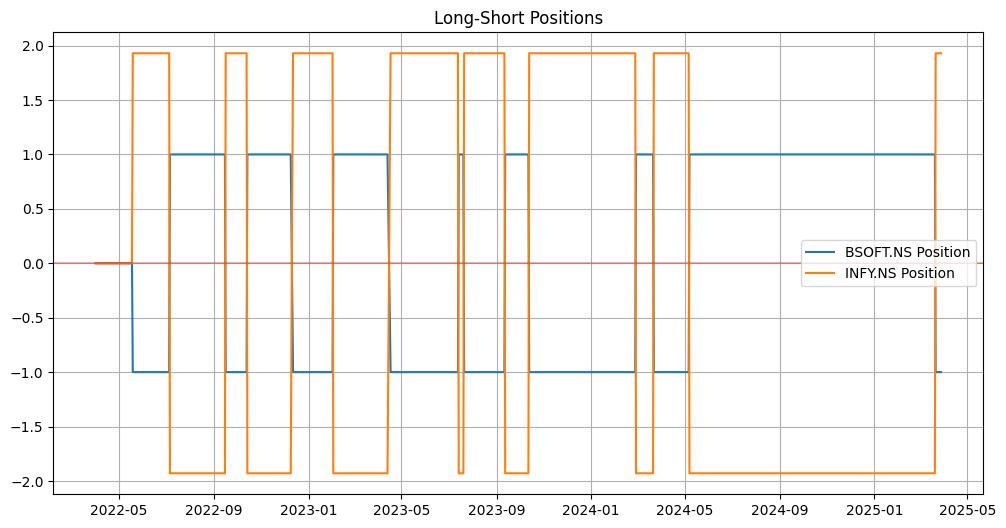

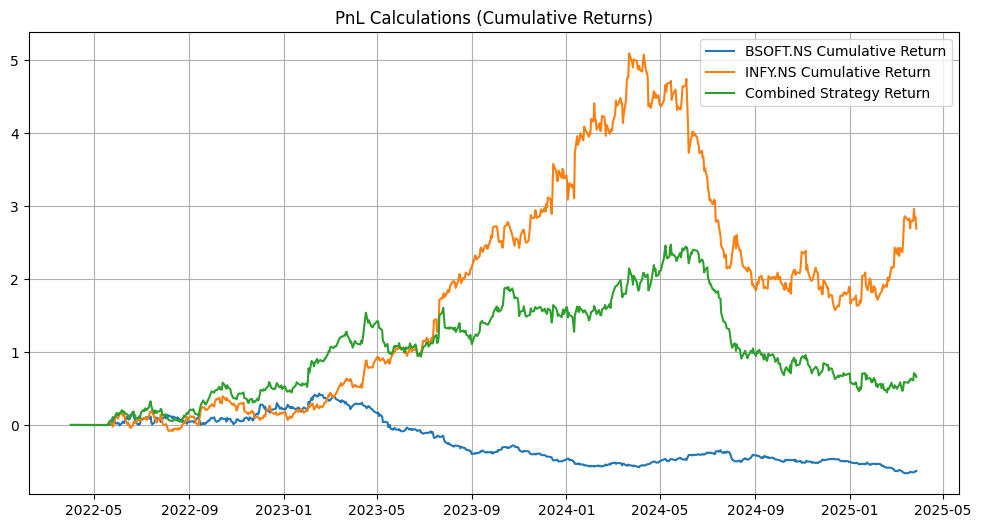

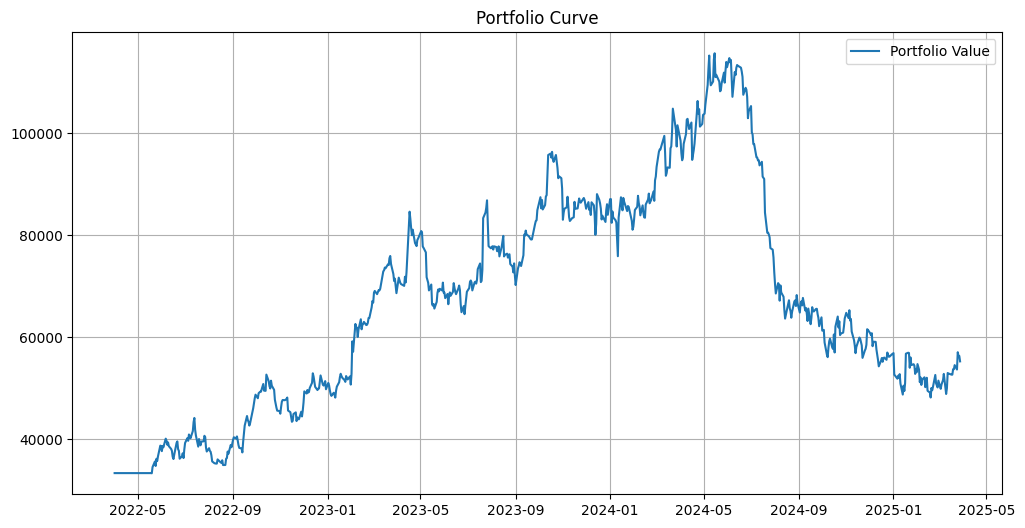

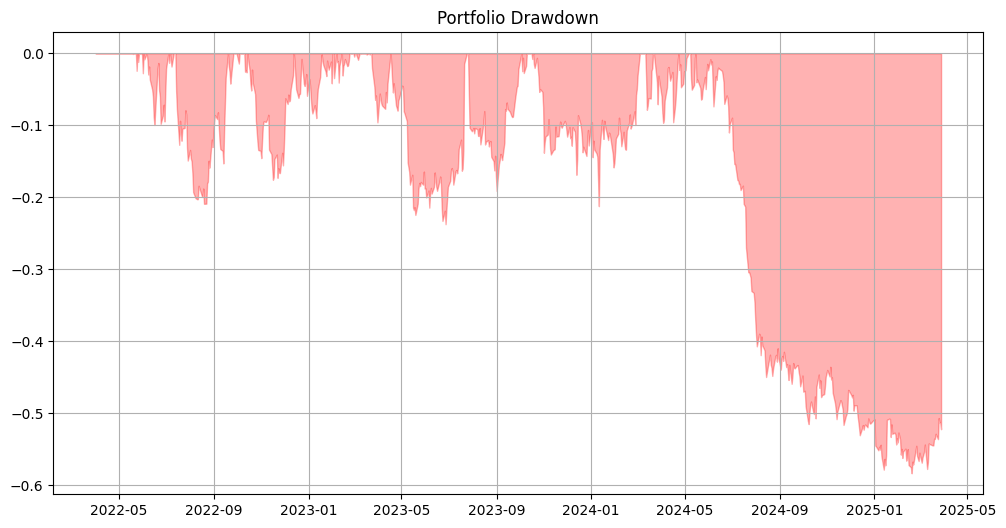


Performance Metrics:
Total Return: 65.75%
Annual Return: 18.78%
Sharpe Ratio: 0.62
Max Drawdown: -58.37%
Win Rate: 48.17%
Number of Trades: 15





In [18]:
def main():

    symbols = [
         "TCS.NS", "INFY.NS", "HCLTECH.NS", "WIPRO.NS", "TECHM.NS",
    "LTIM.NS", "MPHASIS.NS", "COFORGE.NS", "PERSISTENT.NS",
    "SONATSOFTW.NS", "LTTS.NS", "ZENSARTECH.NS", "KPITTECH.NS", "TATAELXSI.NS",
    "CYIENT.NS", "BSOFT.NS", "ECLERX.NS", "INTELLECT.NS", "NEWGEN.NS",
    "DATAMATICS.NS", "TANLA.NS",  "RPSGVENT.NS", "OFSS.NS"
    ]


    training_start_date = '2019-04-01'
    training_end_date = '2022-03-31'
    testing_start_date = '2022-04-01'
    testing_end_date = '2025-03-31'


    pairs_trading = PairsTrading(
        symbols=symbols,
        start_date=training_start_date,
        end_date=testing_end_date,
        initial_capital=100000
    )


    pairs_trading.load_data()


    pairs_trading.find_cointegrated_pairs(
        training_start_date=training_start_date,
        training_end_date=training_end_date
    )


    pairs_trading.select_best_pairs(max_pairs=3)


    pairs_trading.backtest_portfolio(
        training_start_date=training_start_date,
        training_end_date=training_end_date,
        testing_start_date=testing_start_date,
        testing_end_date=testing_end_date,
        entry_threshold=2.0,
        exit_threshold=0.0,
        lookback=30,
        transaction_cost=0.001
    )


    pairs_trading.plot_portfolio_performance()


    pairs_trading.portfolio_performance_metrics()


    for pair, result in pairs_trading.results.items():
        print(f"\nAnalyzing pair: {pair[0]}-{pair[1]}")
        pairs_trading.plot_closing_prices(result)
        print("\n")
        pairs_trading.plot_rel_close_price(result)
        print("\n")
        pairs_trading.plot_zscore(result)
        print("\n")
        pairs_trading.plot_long_short_positions(result)
        print("\n")
        pairs_trading.plot_PnL(result)
        print("\n")
        pairs_trading.plot_portfolio_curve(result)
        print("\n")
        pairs_trading.plot_drawdown(result)
        # print("\n")
        pairs_trading.performance_metrics(result)
        print("\n\n")


if __name__ == "__main__":
    main()
